## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

## Basic Elements

In [2]:
class Rand:
    @staticmethod
    def exp(time_mean):
        a = 0
        while a == 0:
            a = np.random.rand()
        return -time_mean * np.log(a)
    
    @staticmethod
    def unif(time_min, time_max):
        a = 0
        while a == 0:
            a = np.random.rand()
        a = time_min + a * (time_max - time_min)
        return a
    
    @staticmethod
    def norm(time_mean, time_deviation):
        return np.random.normal(loc=time_mean, scale=time_deviation)

In [3]:
class Element:
    id_curr = 0
    
    def __init__(self, name=None, delay_mean=1., delay_dev=0., distribution='', p=None, n_channel=1):
        self.n_channel = n_channel
        self.tnexts = [0.0]*self.n_channel
        self.delay_mean = delay_mean
        self.delay_dev = delay_dev
        self.distribution = distribution
        self.quantity = 0
        self.tcurr = 0
        self.states = [0]*self.n_channel
        self.next_elements = None
        self.p = p
        self.id_curr = Element.id_curr
        Element.id_curr += 1
        self.name = f'element_{self.id_curr}' if name is None else name
        
    def get_delay(self):
        if self.distribution == 'exp':
            return Rand.exp(self.delay_mean)
        elif self.distribution == 'unif':
            return Rand.unif(self.delay_mean, self.delay_dev)
        elif self.distribution == 'norm':
            return Rand.norm(self.delay_mean, self.delay_dev)
        else:
            return self.delay_mean
        
    def in_act(self):
        pass
    
    def out_act(self):
        self.quantity += 1
        
    def print_info(self):
        print(f'{self.name}: state={self.states}; quantity={self.quantity}; tnext={np.round(self.tnexts, 5)}')
        
    def print_result(self):
        print(f'{self.name}: state={self.states}; quantity={self.quantity};\n')
    
    def do_statistics(self, delta):
        pass
    
    def find_free_channels(self):
        res = []
        for i in range(self.n_channel):
            if self.states[i] == 0:
                res.append(i)
        return res
        
    def find_current_channels(self):
        res = []
        for i in range(self.n_channel):
            if self.tnexts[i] == self.tcurr:
                res.append(i)
        return res

In [4]:
class Create(Element):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def out_act(self):
        # виконуємо збільшення лічильника кількості
        super().out_act()
        # встановлюємо коли пристрій буде вільним
        self.tnexts[0] = self.tcurr + super().get_delay()
        # передаємо створену заявку на настпуні елемент
        next_element = np.random.choice(self.next_elements, p=self.p)
        next_element.in_act()

In [5]:
class Despose(Element):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tnexts = [np.inf]
        
    def in_act(self):
        # виконуємо збільшення лічильника кількості
        super().out_act()
        
    def out_act(self):
        pass

In [6]:
class Process(Element):
    def __init__(self, maxqueue=np.inf, n_channel=1, **kwargs):
        super().__init__(**kwargs)
        self.queue = 0
        self.n_channel = n_channel
        self.maxqueue = maxqueue
        self.mean_queue_length = 0
        self.max_obs_queue_length = self.queue
        self.failure = 0
        self.tnexts = [np.inf]*n_channel
        self.states = [0]*n_channel
        
    def in_act(self):
        # перевіряємо чи вільний пристрій
        free_channels = self.find_free_channels()
        for i in free_channels:
            # позначаємо що пристрій зайнятий
            self.states[i] = 1
            # встановлюємо коли пристрій буде вільним
            self.tnexts[i] = self.tcurr + super().get_delay()
            break
        else:
            if self.queue < self.maxqueue:
                self.queue += 1
                if self.queue > self.max_obs_queue_length:
                    self.max_obs_queue_length = self.queue
            else:
                self.failure += 1
            
    def out_act(self):
        # виконуємо збільшення лічильника кількості
        super().out_act()
        
        current_channels = self.find_current_channels()
        
        for i in current_channels:
            # позначаємо, що елемент вільний
            self.tnexts[i] = np.inf
            self.states[i] = 0

            # дістаємо з черги елемент, якщо він там є
            if self.queue > 0:
                self.queue -= 1
                self.states[i] = 1
                self.tnexts[i] = self.tcurr + super().get_delay()
            elif self.next_elements is not None:
                next_element = np.random.choice(self.next_elements, p=self.p)
                next_element.in_act()
        
    def print_info(self):
        super().print_info()
        print(f'failure={self.failure}')
        
    def do_statistics(self, delta):
        self.mean_queue_length += delta * self.queue
#         print(self.mean_queue_length)

In [7]:
class Model():
    def __init__(self, elements=[], print_logs=False):
        self.elements = elements
        self.tnext = 0
        self.tcurr = self.tnext
        self.event = elements[0]
        self.print_logs = print_logs
        
    def simulate(self, time):
        self.max_time = time
        while self.tcurr < self.max_time:
            self.tnext = np.inf
            for e in self.elements:
                # знайти найменший з моментів часу
                t_next_min = np.min(e.tnexts)
                if t_next_min < self.tnext and not isinstance(e, Despose):
                    self.tnext = t_next_min
                    self.event = e
#             if self.print_logs:
#                 print(f'\nIt`s time for event in {self.event.name}; time={np.round(self.tnext, 5)}')
            
            # обраховуємо статистики
            for e in self.elements:
                e.do_statistics(self.tnext - self.tcurr)
                
            # робимо переміщення до моменту завершення
            self.tcurr = self.tnext
            for e in self.elements:
                e.tcurr = self.tcurr
            
            # виконуємо операцію завершення
            self.event.out_act()
            
            # Щоб зменшити обсяг обчислень, введемо також здійснення відповідної події для всіх елементів,
            # час наступної події яких співпадає з поточним моментом часу
            for e in self.elements:
                if self.tcurr in e.tnexts:
                    e.out_act()
#             if self.print_logs:        
#                 self.print_info()
        return self.print_result()
        
    def print_info(self):
        for e in self.elements:
            e.print_info()
            
    def print_result(self):
        if self.print_logs:
            print('-----RESULT-----')
        
        global_max_observed_queue_length = 0
        global_mean_queue_length_accumulator = 0
        global_failure_probability_accumulator = 0
        global_max_load = 0
        global_mean_load_accumulator = 0
        num_of_processors = 0
        
        for e in self.elements:
            if self.print_logs:
                e.print_result()
            if isinstance(e, Process):
                num_of_processors += 1
                mean_queue_length = e.mean_queue_length / self.tcurr
                failure_probability = e.failure / (e.quantity + e.failure) if (e.quantity + e.failure) != 0 else 0
                mean_load = e.quantity / self.max_time
                
                global_mean_queue_length_accumulator += mean_queue_length
                global_failure_probability_accumulator += failure_probability
                global_mean_load_accumulator += mean_load
                
                if e.max_obs_queue_length > global_max_observed_queue_length:
                    global_max_observed_queue_length = e.max_obs_queue_length
                    
                if mean_load > global_max_load:
                    global_max_load = mean_load
                
                if self.print_logs:
                    print(f"Average queue length: {mean_queue_length}")
                    print(f"Failure probability: {failure_probability}")
                    print(f"Average load: {mean_load}")
                    print()
                
        global_mean_queue_length = global_mean_queue_length_accumulator / num_of_processors
        global_failure_probability = global_failure_probability_accumulator / num_of_processors
        global_mean_load = global_mean_load_accumulator / num_of_processors
        
        if self.print_logs:
            print(f"Global max observed queue length: {global_max_observed_queue_length}")
            print(f"Global mean queue length: {global_mean_queue_length}")
            print(f"Global failure probability: {global_failure_probability}")
            print(f"Global max load: {global_max_load}")
            print(f"Global mean load: {global_mean_load}")
            print()
        
        return self.elements[0].quantity

In [8]:
def compute_perc(x, y):
    return 100 * (np.abs(np.array(x) - np.array(y))) / np.max([np.max(x), np.max(y)])

## Task 1

### Розробити модель масового обслуговування, яка складається з N систем масового обслуговування. Число N є параметром моделі. Кількість подій в моделі оцінюється числом N+1

In [9]:
class SimModel():
    def __init__(self):
        c1 = Create(delay_mean=0.89, name='CREATOR_1', distribution='exp')
#         c1 = Create(delay_mean=2.0, name='CREATOR_1', distribution='exp')
        p1 = Process(maxqueue=100, delay_mean=0.6, name='PROCESSOR1', distribution='exp')
        p2 = Process(maxqueue=100, delay_mean=0.3, name='PROCESSOR2', distribution='exp')
        p3 = Process(maxqueue=100, delay_mean=0.4, name='PROCESSOR3', distribution='exp')
        p4 = Process(maxqueue=100, delay_mean=0.1, name='PROCESSOR4', distribution='exp', n_channel=2)
        d1 = Despose(name='DESPOSE1')

        c1.next_elements = [p1]
        p1.next_elements = [d1, p2, p3, p4]
        p2.next_elements = [p1]
        p3.next_elements = [p1]
        p4.next_elements = [p1]
        
        p1.p = [0.42, 0.15, 0.13, 0.3]
        
        elements = [c1, p1, p2, p3, p4, d1]
        model = Model(elements, print_logs=True)
        model.simulate(10000)

In [10]:
Element.id_curr = 0
s = SimModel()

-----RESULT-----
CREATOR_1: state=[0]; quantity=11141;

PROCESSOR1: state=[1]; quantity=13480;

Average queue length: 1.736130784527018
Failure probability: 0.0
Average load: 1.348

PROCESSOR2: state=[0]; quantity=604;

Average queue length: 7.453470902091766e-05
Failure probability: 0.0
Average load: 0.0604

PROCESSOR3: state=[0]; quantity=537;

Average queue length: 0.00038088335743142836
Failure probability: 0.0
Average load: 0.0537

PROCESSOR4: state=[0, 0]; quantity=1216;

Average queue length: 0.0
Failure probability: 0.0
Average load: 0.1216

DESPOSE1: state=[0]; quantity=1629;

Global max observed queue length: 21
Global mean queue length: 0.4341465506483676
Global failure probability: 0.0
Global max load: 1.348
Global mean load: 0.395925



## Task 2

### Виконати експериментальну оцінку складності алгоритму імітації мережі масового обслуговування. Для цього виконайте серію експериментів, в якій спостерігається збільшення часу обчислення алгоритму імітації при збільшенні кількості подій в моделі.

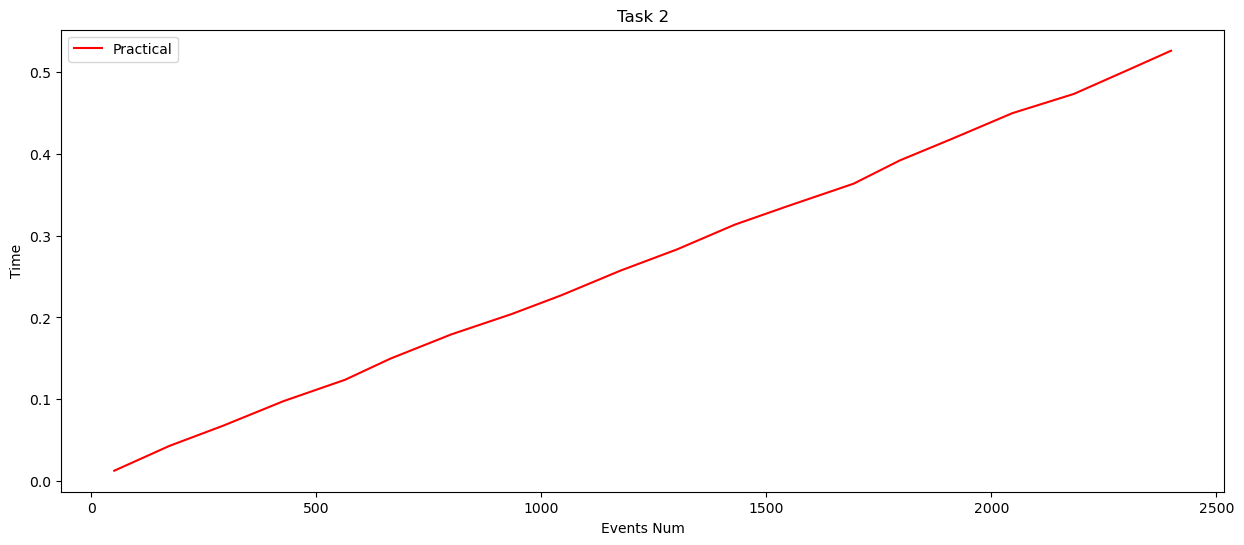

In [11]:
N = 10
time_modeling_list = range(100, 5000, 250)

times_list = []
events_list = []

for time_modeling in time_modeling_list:
    current_events_list = []
    current_times_list = []
    for _ in range(N):
        Element.id_curr = 0
        c1 = Create(delay_mean=2, name='CREATOR_1', distribution='exp')
        p1 = Process(maxqueue=100, delay_mean=0.6, name='PROCESSOR1', distribution='exp')
        p2 = Process(maxqueue=100, delay_mean=0.3, name='PROCESSOR2', distribution='exp')
        p3 = Process(maxqueue=100, delay_mean=0.4, name='PROCESSOR3', distribution='exp')
        p4 = Process(maxqueue=100, delay_mean=0.1, name='PROCESSOR4', distribution='exp', n_channel=2)
        d1 = Despose(name='DESPOSE1')

        c1.next_elements = [p1]
        p1.next_elements = [d1, p2, p3, p4]
        p2.next_elements = [p1]
        p3.next_elements = [p1]
        p4.next_elements = [p1]

        p1.p = [0.42, 0.15, 0.13, 0.3]

        elements = [c1, p1, p2, p3, p4, d1]
        model = Model(elements, print_logs=False)
        
        start = time.time()
        quantity = model.simulate(time_modeling)
        current_times_list.append(time.time() - start)
        current_events_list.append(quantity)
        
        
    times_list.append(np.sum(current_times_list) / N)
    events_list.append(np.sum(current_events_list) / N)
    
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.lineplot(x='Events Num', y='Time', data=pd.DataFrame(list(zip(events_list, times_list)), 
            columns=['Events Num', 'Time']), label=f'Practical', ax=ax, color='red')

ax.set_title(u'Task 2');

## Task 3

### Виконати теоретичну оцінку складності побудованого алгоритму імітації

Error: 14.691874


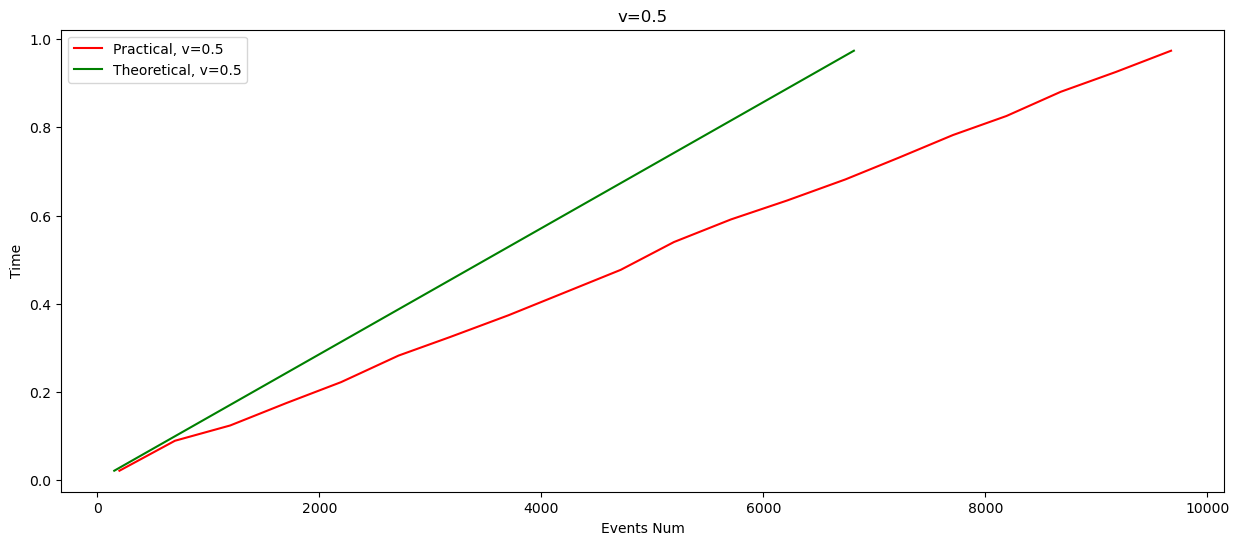

Error: 22.443612


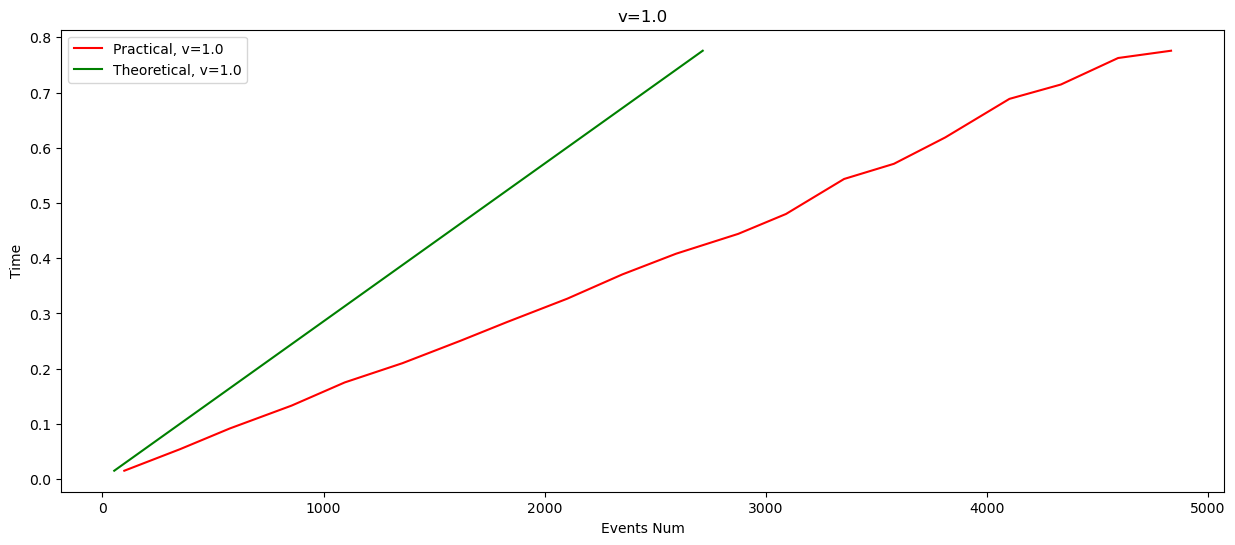

Error: 28.240597


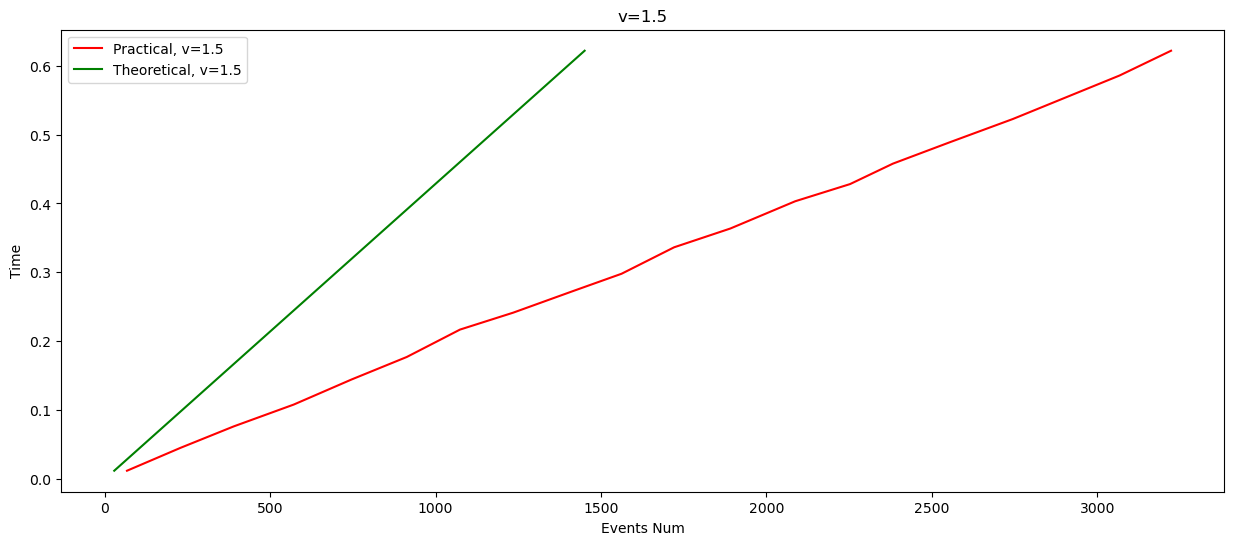

In [12]:
N = 10
v_list = np.arange(0.5, 2.0, 0.5)
time_modelig_list = range(100, 1500, 100)

for v in v_list:
    times_list = []
    events_list = []
    events_theory = []
    for time_modeling in time_modeling_list:
        current_events_list = []
        current_times_list = []

        for _ in range(N):
            Element.id_curr = 0
            c1 = Create(delay_mean=v, name='CREATOR_1', distribution='exp')
            p1 = Process(maxqueue=100, delay_mean=0.6, name='PROCESSOR_1', distribution='exp')
            p2 = Process(maxqueue=100, delay_mean=0.3, name='PROCESSOR_2', distribution='exp')
            p3 = Process(maxqueue=100, delay_mean=0.4, name='PROCESSOR_3', distribution='exp')
            p4 = Process(maxqueue=100, delay_mean=0.1, name='PROCESSOR_4', distribution='exp', n_channel=2)
            d1 = Despose(name='DESPOSE_1')

            c1.next_elements = [p1]
            p1.next_elements = [d1, p2, p3, p4]
            p2.next_elements = [p1]
            p3.next_elements = [p1]
            p4.next_elements = [p1]

            p1.p = [0.42, 0.15, 0.13, 0.3]

            elements = [c1, p1, p2, p3, p4, d1]
            model = Model(elements, print_logs=False)

            start = time.time()
            quantity = model.simulate(time_modeling)
            current_times_list.append(time.time() - start)
            current_events_list.append(quantity)


        times_list.append(np.sum(current_times_list) / N)
        events_list.append(np.sum(current_events_list) / N)
        events_theory.append((np.sum(current_times_list) / N) * (1 / v) * 3500)

    print('Error: %f' % np.mean(compute_perc(events_list, events_theory)))
    fig, ax = plt.subplots(1,1, figsize=(15,6))

    sns.lineplot(x='Events Num', y='Time', data=pd.DataFrame(list(zip(events_list, times_list)), 
                columns=['Events Num', 'Time']), label=f'Practical', ax=ax, color='red')

    sns.lineplot(x='Events Num', y='Time', data=pd.DataFrame(list(zip(events_theory, times_list)), 
                columns=['Events Num', 'Time']), label=f'Theoretical', ax=ax, color='green')

    ax.set_title(f'v={v}');
    plt.show()

## Task 4

### Повторіть експеримент при зміні структури мережі масового обслуговування.

Error: 20.116920


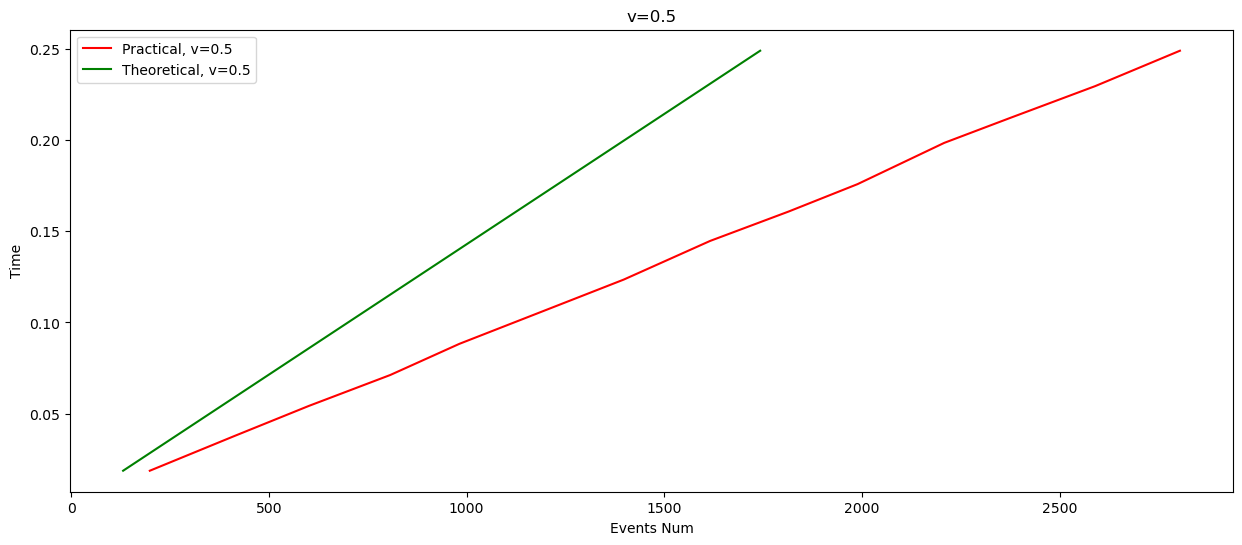

Error: 27.187331


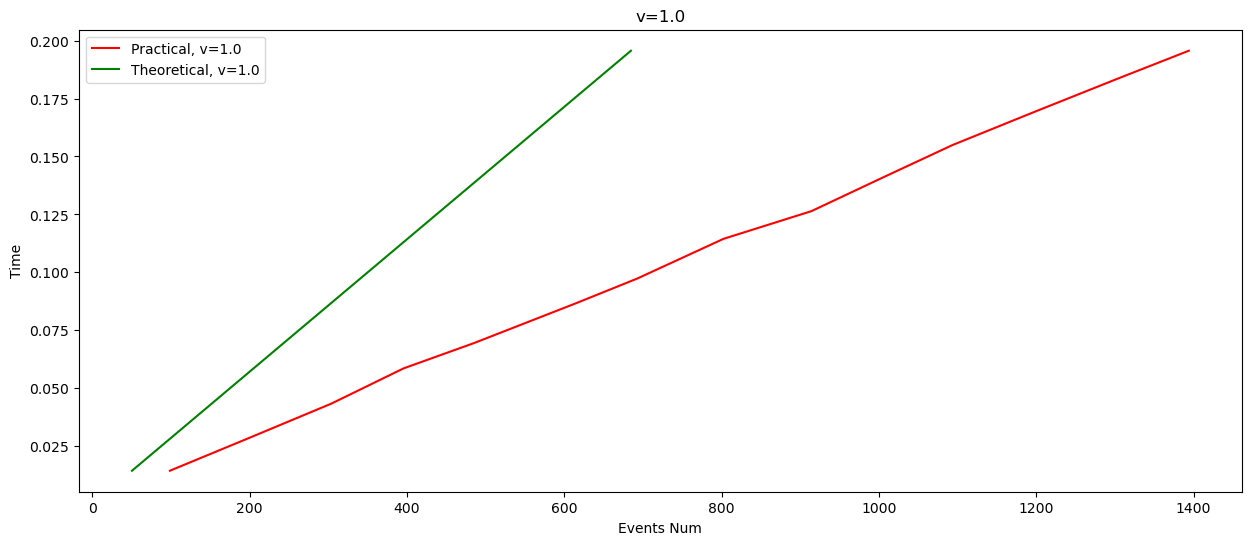

Error: 31.206637


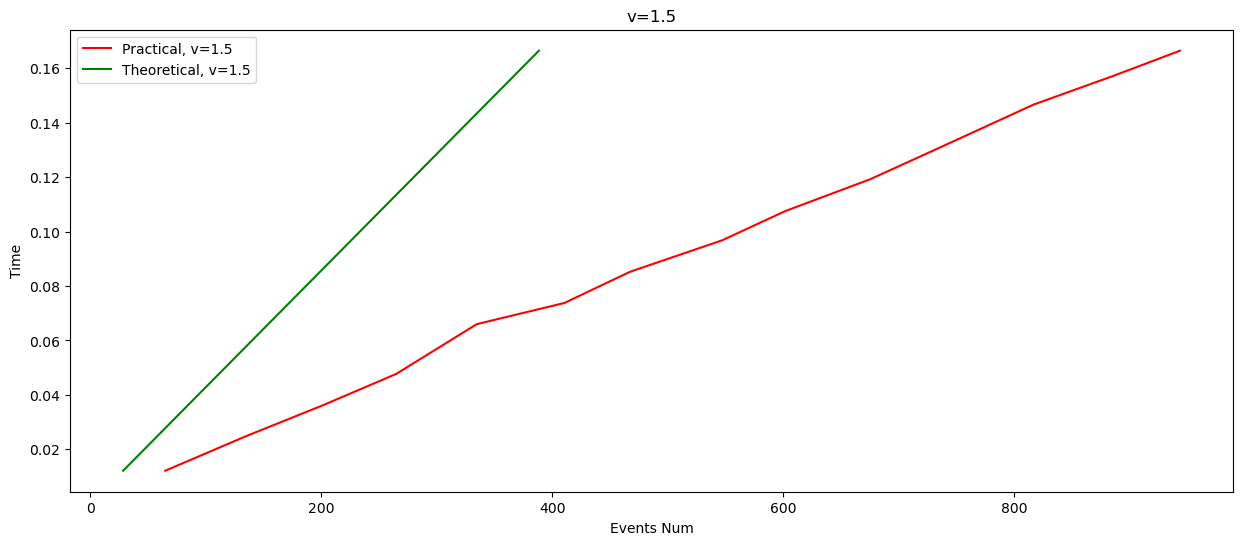

In [13]:
N = 10
v_list = np.arange(0.5, 2.0, 0.5)
time_modeling_list = range(100, 1500, 100)

for v in v_list:
    times_list = []
    events_list = []
    events_theory = []
    for time_modeling in time_modeling_list:
        current_events_list = []
        current_times_list = []

        for _ in range(N):
            Element.id_curr = 0
            c1 = Create(delay_mean=v, name='CREATOR_1', distribution='exp')
            p1 = Process(maxqueue=100, delay_mean=0.6, name='PROCESSOR_1', distribution='exp')
            p2 = Process(maxqueue=100, delay_mean=0.3, name='PROCESSOR_2', distribution='exp', n_channel=2)
            p3 = Process(maxqueue=100, delay_mean=0.4, name='PROCESSOR_3', distribution='exp')
            d1 = Despose(name='DESPOSE_1')

            c1.next_elements = [p1]
            p1.next_elements = [d1, p2, p3]
            p2.next_elements = [p1]
            p3.next_elements = [p2]

            p1.p = [0.42, 0.25, 0.33]

            elements = [c1, p1, p2, p3, d1]
            model = Model(elements, print_logs=False)

            start = time.time()
            quantity = model.simulate(time_modeling)
            current_times_list.append(time.time() - start)
            current_events_list.append(quantity)


        times_list.append(np.sum(current_times_list) / N)
        events_list.append(np.sum(current_events_list) / N)
        events_theory.append((np.sum(current_times_list) / N) * (1 / v) * 3500)
        
    print('Error: %f' % np.mean(compute_perc(events_list, events_theory)))

    fig, ax = plt.subplots(1,1, figsize=(15,6))

    sns.lineplot(x='Events Num', y='Time', data=pd.DataFrame(list(zip(events_list, times_list)), 
                columns=['Events Num', 'Time']), label=f'Practical', ax=ax, color='red')

    sns.lineplot(x='Events Num', y='Time', data=pd.DataFrame(list(zip(events_theory, times_list)), 
                columns=['Events Num', 'Time']), label=f'Theoretical', ax=ax, color='green')

    ax.set_title(f'v={v}');
    plt.show()